# Get the original text data, import libs, and show some samples

In [1]:
!wget https://huggingface.co/datasets/bezirganyan/LUMA/resolve/main/text_data.tsv

--2024-11-26 13:04:15--  https://huggingface.co/datasets/bezirganyan/LUMA/resolve/main/text_data.tsv
Resolving huggingface.co (huggingface.co)... 3.167.112.45, 3.167.112.25, 3.167.112.96, ...
Connecting to huggingface.co (huggingface.co)|3.167.112.45|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/91/6d/916d91190e01032d29384546038721047bf54420deab1052a661200d4b695d3d/34fdb88e6c762deda6bc625f7eb51394a584ff9306a9d7753ab223859754e42a?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27text_data.tsv%3B+filename%3D%22text_data.tsv%22%3B&response-content-type=text%2Ftab-separated-values&Expires=1732885455&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczMjg4NTQ1NX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzkxLzZkLzkxNmQ5MTE5MGUwMTAzMmQyOTM4NDU0NjAzODcyMTA0N2JmNTQ0MjBkZWFiMTA1MmE2NjEyMDBkNGI2OTVkM2QvMzRmZGI4OGU2Yzc2MmRlZGE2YmM2MjVmN2ViNTEzOTRhNTg0ZmY5MzA2YTlk

In [6]:
import pandas as pd
import random
import os
from tqdm.notebook import tqdm

In [3]:
data = pd.read_csv('text_data.tsv', sep='\t')

In [4]:
print(f'lenght of data: {len(data)}')

lenght of data: 62875


In [5]:
idx = random.randint(0, len(data))
print(f'sample {idx} \nText: {data.loc[idx].text} \nLabel: {data.loc[idx].label}')

sample 36609 
Text: A rabbit is a fluffy and cuddly animal that lives in a burrow. It is known for its quick hopping, soft fur, and sweet teeth. Rabbits are often kept as pets. They eat carrots, lettuce, and other vegetables. 
Label: rabbit


# Testing some models

We first filter the biases from non biased

## Binary classifier

based on the bias-detection-model model

### Inference

In [7]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("d4data/bias-detection-model")
model = TFAutoModelForSequenceClassification.from_pretrained("d4data/bias-detection-model")

classifier = pipeline('text-classification', model=model, tokenizer=tokenizer, device=0) # cuda = 0,1 based on gpu availability

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/657 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/268M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at d4data/bias-detection-model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [8]:
# test on one sample

output = classifier(data.loc[idx].text)
output[0]

In [9]:
data['text_length'] = data['text'].str.len()
data_sorted = data.sort_values(by='text_length')

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['text']
        return {
            'text': text,
        }

# Example usage
BATCH_SIZE = 32 # Adjust as needed

dataset = TextDataset(data_sorted)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
# Batching the input
i = 0
results = []
for batch in tqdm(dataloader):
    i += 1
    try:
        batch_results = classifier(batch['text'])
        results.extend(batch_results)
    except Exception as e:
        print(f"Error processing batch {i}: {e}")

  0%|          | 0/1965 [00:00<?, ?it/s]

In [19]:
data_sorted['results'] = results
data_sorted.to_csv('binary_classification_results.csv', index=False)

In [20]:
data_sorted

,text,label,text_length,results
17416,A bottle of water vapor suspended in the air,cloud,44,"{'label': 'Non-biased', 'score': 0.67796951532..."
18020,"A fox is quick and sly, it's a cunning animal.",fox,46,"{'label': 'Non-biased', 'score': 0.59829854965..."
46835,Plain clothes are comfortable to wear all day.,plain,46,"{'label': 'Biased', 'score': 0.6522274017333984}"
48252,We often gather around the table to eat and chat.,table,49,"{'label': 'Biased', 'score': 0.5837098956108093}"
4710,I'm planning on moving into a new house next m...,house,51,"{'label': 'Non-biased', 'score': 0.67790681123..."
...,...,...,...,...
17460,Clouds have traversed a storied path throughou...,cloud,1483,"{'label': 'Biased', 'score': 0.9771029949188232}"
19562,"Opuut: Castles, majestic structures steeped in...",castle,1486,"{'label': 'Biased', 'score': 0.9805306196212769}"
31717,"The frog, a beloved amphibian creature, has a ...",frog,1490,"{'label': 'Biased', 'score': 0.9920835494995117}"
17456,"Cloud, a wispy, ethereal aggregation, made of ...",cloud,1492,"{'label': 'Biased', 'score': 0.7810251712799072}"


### Or load the data

In [47]:
if os.path.exists('binary_classification_results.csv'):
    data_sorted = pd.read_csv('binary_classification_results.csv')
else:
  print('file not found, run the inference first')

In [28]:
data_sorted.head()

,text,label,text_length,results
0,A bottle of water vapor suspended in the air,cloud,44,"{'label': 'Non-biased', 'score': 0.67796951532..."
1,"A fox is quick and sly, it's a cunning animal.",fox,46,"{'label': 'Non-biased', 'score': 0.59829854965..."
2,Plain clothes are comfortable to wear all day.,plain,46,"{'label': 'Biased', 'score': 0.6522274017333984}"
3,We often gather around the table to eat and chat.,table,49,"{'label': 'Biased', 'score': 0.5837098956108093}"
4,I'm planning on moving into a new house next m...,house,51,"{'label': 'Non-biased', 'score': 0.67790681123..."


In [48]:
def get_bias_label(data, threshold = 0.9):
    # Extract label and score into separate columns
    data['bias_label'] = data['results'].apply(lambda x: 'Biased' if eval(x)['score'] > threshold else 'Non-biased')
    data['score'] = data['results'].apply(lambda x: eval(x)['score'])
    return data

In [52]:
data_sorted = get_bias_label(data_sorted, threshold = 0.98)

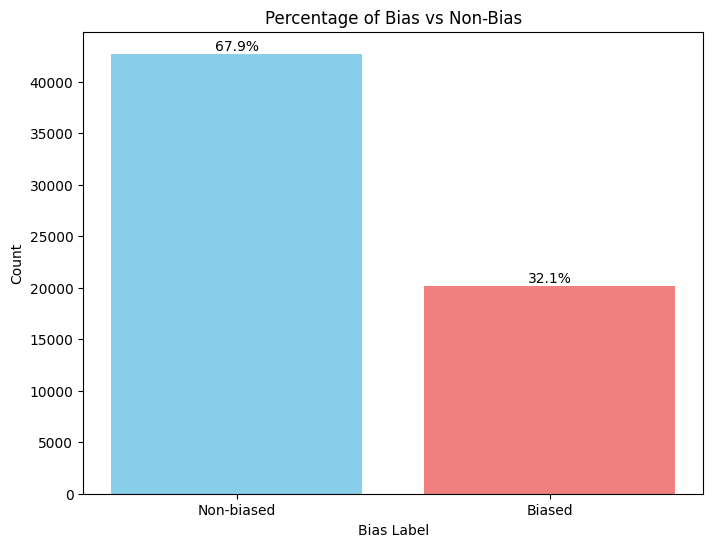

In [53]:
bias_counts = data_sorted['bias_label'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(bias_counts.index, bias_counts.values, color=['skyblue', 'lightcoral'])

plt.xlabel('Bias Label')
plt.ylabel('Count')
plt.title('Percentage of Bias vs Non-Bias')

# Add percentage labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, f'{yval/len(data_sorted)*100:.1f}%', ha='center', va='bottom')


plt.show()

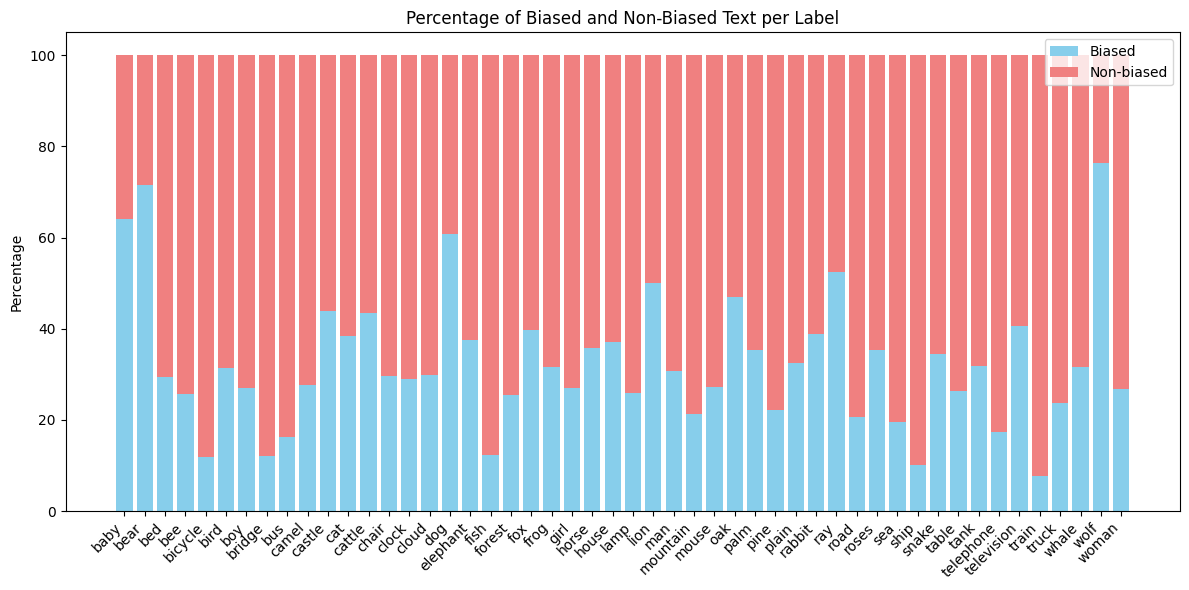

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming data_sorted DataFrame is already loaded as in the provided code

# Group data by label and bias_label
label_bias_counts = data_sorted.groupby(['label', 'bias_label']).size().unstack(fill_value=0)

# Calculate percentages
label_bias_percentages = label_bias_counts.div(label_bias_counts.sum(axis=1), axis=0) * 100

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust figure size as needed

labels = label_bias_percentages.index
width = 0.8  # Width of each bar

# Colors for biased and non-biased
colors = ['skyblue', 'lightcoral']

# Loop through the labels to create a single bar per label, split by bias
for i, label in enumerate(labels):
    bias_percentage = label_bias_percentages.loc[label, 'Biased']
    non_bias_percentage = label_bias_percentages.loc[label, 'Non-biased']

    # Stacked bar: bottom of the bar starts at 0 for "Biased" and at the height of "Biased" for "Non-biased"
    ax.bar(i, bias_percentage, width, label='Biased' if i == 0 else "", color=colors[0])
    ax.bar(i, non_bias_percentage, width, bottom=bias_percentage, label='Non-biased' if i == 0 else "", color=colors[1])

# Set x-ticks and labels
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Biased and Non-Biased Text per Label')
ax.legend()

plt.tight_layout()
plt.show()


<ipython-input-55-e773b19047c0>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('coolwarm')


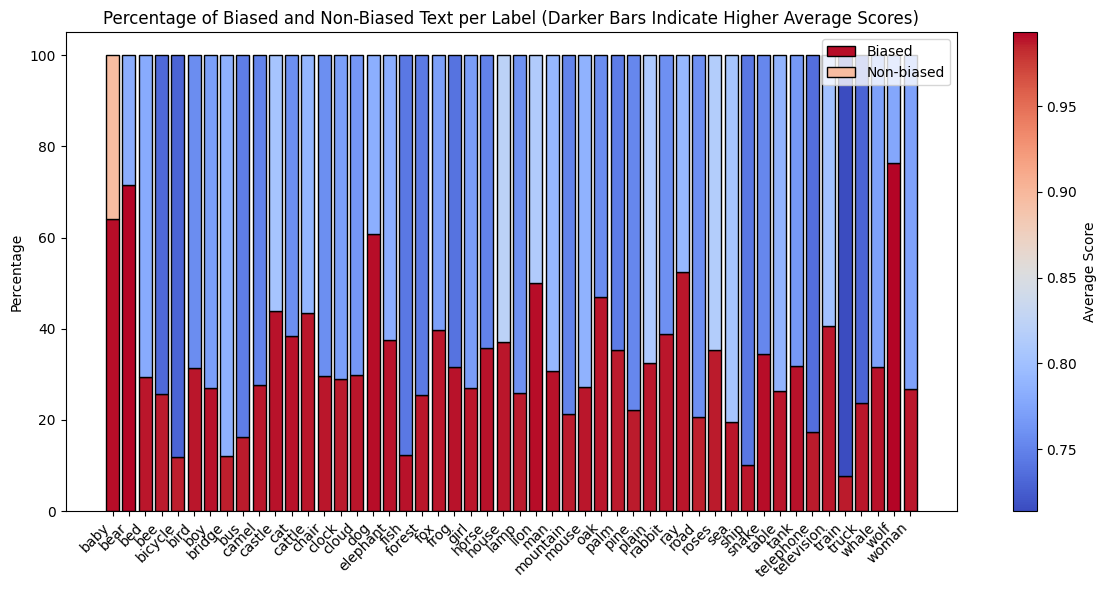

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Assuming data_sorted DataFrame is already loaded with 'label', 'bias_label', and 'score' columns

# Group data by label and bias_label
label_bias_counts = data_sorted.groupby(['label', 'bias_label']).size().unstack(fill_value=0)

# Calculate percentages
label_bias_percentages = label_bias_counts.div(label_bias_counts.sum(axis=1), axis=0) * 100

# Compute average scores
average_scores = data_sorted.groupby(['label', 'bias_label'])['score'].mean().unstack(fill_value=0)

# Normalize average scores to [0, 1] range for color mapping
norm = mcolors.Normalize(vmin=average_scores.min().min(), vmax=average_scores.max().max())
colormap = cm.get_cmap('coolwarm')

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust figure size as needed

labels = label_bias_percentages.index
width = 0.8  # Width of each bar

# Loop through the labels to create a single bar per label, split by bias
for i, label in enumerate(labels):
    # Percentages
    bias_percentage = label_bias_percentages.loc[label, 'Biased']
    non_bias_percentage = label_bias_percentages.loc[label, 'Non-biased']

    # Average scores for color intensity
    bias_avg_score = average_scores.loc[label, 'Biased']
    non_bias_avg_score = average_scores.loc[label, 'Non-biased']

    # Map scores to colors
    bias_color = colormap(norm(bias_avg_score))
    non_bias_color = colormap(norm(non_bias_avg_score))

    # Stacked bar: bottom of the bar starts at 0 for "Biased" and at the height of "Biased" for "Non-biased"
    ax.bar(i, bias_percentage, width, color=bias_color, edgecolor='black', label='Biased' if i == 0 else "")
    ax.bar(i, non_bias_percentage, width, bottom=bias_percentage, color=non_bias_color, edgecolor='black', label='Non-biased' if i == 0 else "")

# Set x-ticks and labels
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Biased and Non-Biased Text per Label (Darker Bars Indicate Higher Average Scores)')
ax.legend()

# Add a colorbar for the score
sm = cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Average Score')

plt.tight_layout()
plt.show()


## Multiclass classification

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="PriyaPatel/bias_identificaiton45")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
classifier(data.loc[idx].text)

[{'label': 'Biased', 'score': 0.9555160403251648}]

In [ ]:
data.loc[idx].text

"The wind whips through your hair,\nA ball of fur, with energy to spare.\nYour tail wags with every beat of your heart,\nA melody of joy, a vibrant start.\n\nYour eyes shine like golden light,\nCleansing the darkest night.\nIn every moment, a pure delight,\nYour presence fills me with delight.\n\nYour bark, a warning, a protective sound,\nA guardian's call, known throughout the ground.\nYou chase, play, and bring me cheer,\nThe best companion, year after year.\n\nYour energy is contagious,\nYou fill me with zest and motivation.\nI want to be like you, full of grace,\nYour spirit ignites, a warm, cozy space.\n\n A dog is a loyal companion, full of joy, with a heart that can bring happiness to all. Their boundless energy, fierce protectiveness, and unconditional love make them the best pets anyone could ask for."